## Exercise is to validate feature importance on Covid Survey Dataset using different regression models

### This notebook is to train various regression models such as OLS, on the covid survey dataset and calculate the feature importance.

### Below models used to train regressors:
    -OLS Regressor
    -Linear Regressor
    -Random Forest Model
    
### Below are the methods used to calculate feature importance
    -P values on OLS Regressor
    -P values of Linear Regressor
    -Inbuilt method to get feat importance of Random Forest model
    -SHAP library on the random forest model
    
Note: Please have a look to read more about how to intepret p-values using link https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/

### Import libraries

In [1]:
import shap
import numpy as np
import pandas as pd 
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


### Import features/columns present in survey

In [2]:
from constants import regression_feat, categorical_feat, index_col, target_col

In [3]:
np.random.seed(1234)

### Load data into dataframe

In [4]:
fans_survey_data = 'covid19-data/Panchayat Survey-FaNS-MGSA(10.05.21).xlsx'
fans_sheet_name = 'Raw Data'

In [5]:
fans_df = pd.read_excel(fans_survey_data, sheet_name = fans_sheet_name)
print("Length : ", len(fans_df))
print(len(fans_df.Identifier.unique()))

Length :  363
198


### Data Cleaning and Data Preparation

In [6]:
# Filter by Repeat No. since data is missing for repeat no other than 1.
fans_df = fans_df[fans_df["Repeat no"] ==1]

#Drop col other than regression_feat, categorical_feat, index_col
query_df = fans_df[[index_col] + regression_feat + categorical_feat ]

# Convert cols in option_ques from nan into 0
for col in categorical_feat:
    query_df[col] = query_df[col].fillna(0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Data Transformation

In [7]:
# Transformation to feed into regressor
answer_map = {'Yes': 1, 'No': 0, 1. : 1, 0.:0}

for col in categorical_feat:
    query_df[col] = query_df[col].map(answer_map)
    
assert (len(query_df[[index_col]]) == len(query_df[index_col].unique()))
query_df.set_index(index_col, inplace=True)
X, y = query_df.drop([target_col], axis=1), query_df[target_col]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### OLS regressor

In [8]:
X2 = sm.add_constant(X)
ols_model = sm.OLS(y, X2)
ols_model = ols_model.fit()
ols_results_summary = ols_model.summary()

ols_results_as_html = ols_results_summary.tables[1].as_html()
ols_result_as_df = pd.read_html(ols_results_as_html, header = 0, index_col = 0)[0]

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


#### To get the feature importance, sort Ascending by p-values

In [9]:
ols_result_as_df = ols_result_as_df.sort_values('P>|t|')

#### Top 15 important features with p values on OLS regressor 

In [10]:
ols_result_as_df.head(15)

,coef,std err,t,P>|t|,[0.025,0.975]
Children (0-6 years),0.3839,0.097,3.964,0.000,0.192,0.575
--OPTION--|Schemes related information and help,-15.4424,5.457,-2.830,0.005,-26.233,-4.652
--OPTION--|Madhya Pradesh Rozgar Setu Yojana,-14.5046,6.616,-2.192,0.030,-27.587,-1.422
--OPTION--|Mask Production,-11.9762,5.642,-2.123,0.036,-23.134,-0.819
Males,-0.2274,0.112,-2.028,0.044,-0.449,-0.006
--OPTION--|Pradhanmantri Gareen Ann Kalyan Yojana,-12.9407,6.654,-1.945,0.054,-26.098,0.217
Total number of Migrant Families who have returned,0.2484,0.133,1.867,0.064,-0.015,0.511
--OPTION--|Sanitizer Production,13.7488,7.729,1.779,0.077,-1.535,29.033
--OPTION--|Group making,9.6586,5.415,1.784,0.077,-1.048,20.365
--OPTION--|Yuva Mandal,12.7968,7.419,1.725,0.087,-1.874,27.468


### Linear Regressor Model

#### Fitted LinearRegression on Train dataset

In [11]:
lr_model = LinearRegression()
lr_model.fit(X,y)
params = np.append(lr_model.intercept_, lr_model.coef_)
predictions = lr_model.predict(X)

In [12]:
# newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

newX = np.append(np.ones((len(X), 1)), X, axis = 1)
MSE = (sum((y - predictions)**2)) / (len(newX) - len(newX[0]))

var_b = MSE * (np.linalg.inv(np.dot(newX.T, newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params / sd_b

p_values =[2 * (1 - stats.t.cdf(np.abs(i) , (len(newX) - len(newX[0])))) for i in ts_b]

In [13]:
sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

lr_model_p_imp = pd.DataFrame()
lr_model_p_imp["Coefficients"], lr_model_p_imp["Standard Errors"], lr_model_p_imp["t_values"], lr_model_p_imp["p_values"] = [params, sd_b, ts_b, p_values]
lr_model_p_imp.index = ['const'] + list(X.columns)

#### To get the feature importance, sort Ascending by p-values

In [14]:
lr_model_p_imp = lr_model_p_imp.sort_values('p_values')

#### Top 15 important features with p values on Linear Regressor

In [15]:
lr_model_p_imp.head(15)

,Coefficients,Standard Errors,t_values,p_values
Children (0-6 years),0.3839,0.097,3.964,0.000
--OPTION--|Schemes related information and help,-15.4424,5.457,-2.830,0.005
--OPTION--|Madhya Pradesh Rozgar Setu Yojana,-14.5046,6.616,-2.192,0.030
--OPTION--|Mask Production,-11.9762,5.642,-2.123,0.036
Males,-0.2274,0.112,-2.028,0.044
--OPTION--|Pradhanmantri Gareen Ann Kalyan Yojana,-12.9407,6.654,-1.945,0.054
Total number of Migrant Families who have returned,0.2484,0.133,1.867,0.064
--OPTION--|Sanitizer Production,13.7488,7.729,1.779,0.077
--OPTION--|Group making,9.6586,5.415,1.784,0.077
--OPTION--|Yuva Mandal,12.7968,7.419,1.725,0.087


### Random Forest Model

Random forest is a Supervised Learning algorithm which uses ensemble learning method for classification and regression. We need to regress the 'Total Number of COVID Infected' using the features which we have in the survey dataset. So Random forest regressor can be a good starting point.

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [17]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state = np.random.seed(1234))
rf_reg.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
#len(rf_reg.feature_importances_)
rf_reg_feat_imp = pd.DataFrame({'feat_imp' : rf_reg.feature_importances_})
rf_reg_feat_imp.index = Xtrain.columns

#### To get the feature importance, sort Descending by feat_imp

In [19]:
rf_reg_feat_imp = rf_reg_feat_imp.sort_values('feat_imp', ascending=False)

#### Top 15 important features with p values on Random Forest

In [20]:
rf_reg_feat_imp.head(15)

,feat_imp
Children (0-6 years),0.211557
Females,0.095074
Total number of Migrant Families who have returned,0.084434
--OPTION--|Disaster Management Committee,0.052030
Males,0.045179
--OPTION--|Yuva Mandal,0.040539
How many villages are there in your panchayat?,0.029770
--OPTION--|Mask Production,0.029128
Are you aware of various Government Schemes for Migrant Labours who have returned?,0.025936
--OPTION--|Ration kit distribution,0.025931


In [21]:
rf_train = rf_reg.score(Xtrain, ytrain)
rf_cv = cross_val_score(rf_reg, Xtrain, ytrain, cv=5).mean()
rf_test = rf_reg.score(Xtest, ytest)
print('Evaluation of the Random Forest performance\n')
print(f'Training score: {rf_train.round(4)}')
print(f'Cross validation score: {rf_cv.round(4)}')
print(f'Test score: {rf_test.round(4)}')

Evaluation of the Random Forest performance

Training score: 0.8381
Cross validation score: -0.3721
Test score: 0.1125


### SHAP values

In [22]:
# Initialize JavaScript visualization
shap.initjs()

In [23]:
# Create SHAP explainer
explainer = shap.TreeExplainer(rf_reg)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [24]:
# shap force plot for the first prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [25]:
# SHAP values for all predictions
shap.force_plot(explainer.expected_value, shap_values, X)

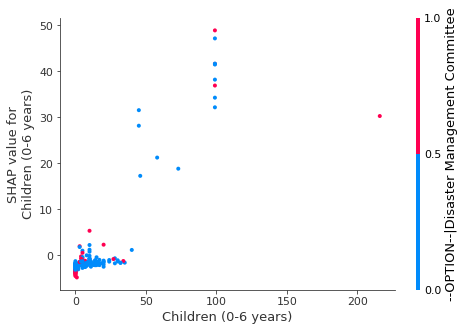

In [26]:
# Effect of a single feature on the shap value,and automatically selected other feature to show dependence 
shap.dependence_plot("Children (0-6 years)", shap_values, X)

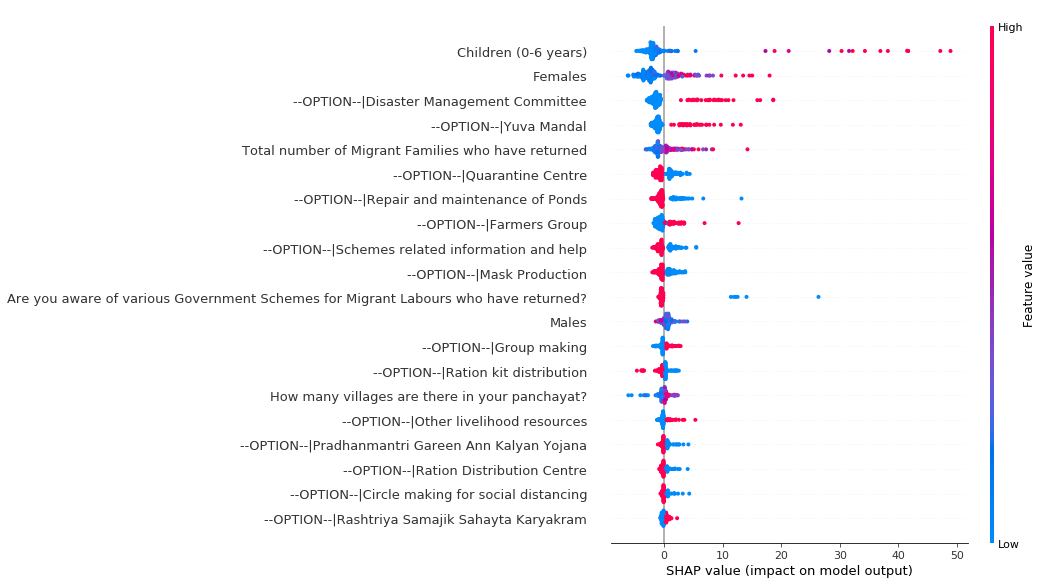

In [27]:
# See how every feature contributes to the model output
shap.summary_plot(shap_values, X)

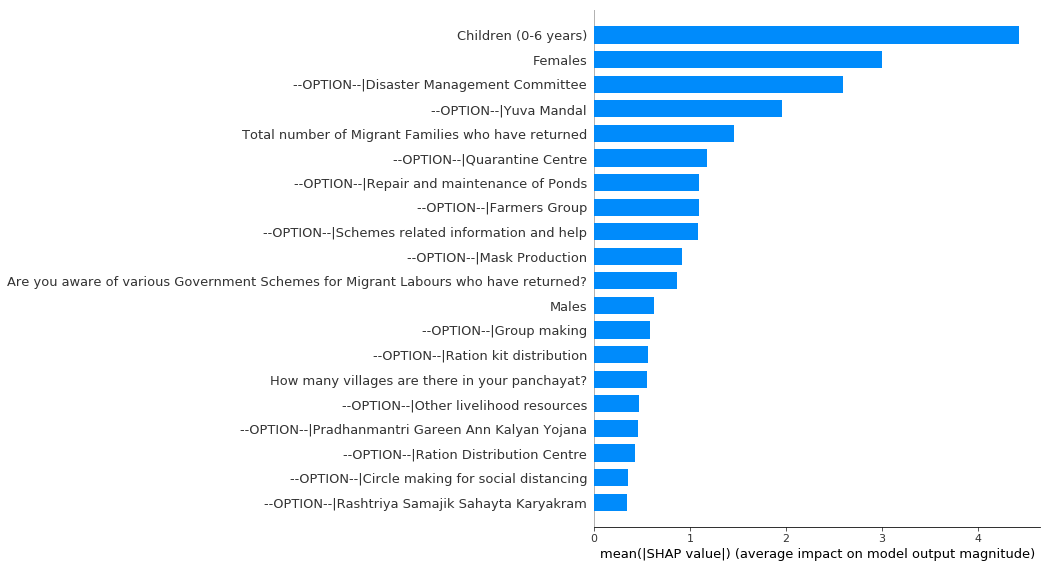

In [28]:
shap.summary_plot(shap_values, X, plot_type="bar")

#### From the above bar plot, below are most important features in regressor of 'Total Number of COVID Infected' with their plausible deductions. 

**"Children (0-6 years)":**
    The panchayat which has more number of children are more likely to have more number of covid cases

**"Total number of Migrant Families who have returned":**
    In panchayat which have more number of returned migrant families, families are more likely to have suspected to covid while traveling.

**"--OPTION--|Mask Production"**
    The panchayat in which people are enganged in work activities such as Mask Production for their livelhood are more likely to have more number of covid cases

**"--OPTION--|Repair and maintenance of Ponds":**
        The panchayat in which people are enganged in work activities such as Repair and maintenance of Ponds for their livelhood are more likely to have more number of covid case

**"--OPTION--|Yuva Mandal":**
    The panchayat which have youth commitess such as Yuva Mandal are more encouraged and people are more willing to get tested and report covid cases instead of hiding their disease for social stigma.

**"--OPTION--|Disaster Management commitees":**
    In the panchayat which have Disaster Management Committee, people are more aware of the covid disease and are confident and willing to trust the panchayat and come forward in cases on covid symptoms. So more covid cases may be reported
    
#### Note: It is a humane interpretation based on limited data which may have deviations from the real factors. Explainations should be take with a grain of salt.